# Лабораторная работа 5. Решающие деревья и леса. Кластеризация и понижение размерности.

## Общая информация

Дата выдачи: 31.05.2016

Срок сдачи: 15.06.2016 09:00MSK


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 15 баллов. Обратите внимание, что только за реализацию функций без подтверждения их корректной работы оценка выставляться не будет.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить задание на указанных в ответном письме условиях.

Задание выполняется САМОСТОЯТЕЛЬНО. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Если вы будете решать задание на виртуальной машине, учтите, что его могут видеть все. К тому же недоступность виртуальной машины не является уважительной причиной для продления дедлайна.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: Username_(group)_Lab4.ipynb, где Username — ваша фамилия на латинице, group — название группы (например, Kozlova_IAD-11_Lab5.ipynb). Далее отправьте этот файл на используемую в Вашей группе почту курса (hse.minor.dm@gmail.com) c темой письма [ИАД-NN] - Лабораторная работа 5 - Фамилия Имя Отчество.

## Решающие деревья и леса

Давайте рассмотрим следующую задачу: зная информацию о пациенте попробуем предсказать есть ли у него сердечное заболевание. Каждый пациент будет описываться 13 признаками, включающими в себя возраст, пол, информацию из электрокардиограммы и т.д.

Загрузите данные из файла *heart.dat.txt*, используя пандас, в переменную *data* (разделитель полей — пробел). Значение целевой переменной находится в последней колонке (*Absence_(1)_or_presence_(2)_of_heart_disease*). 

In [71]:
import pandas as pd
 
data = pd.read_csv("heart.dat.txt", sep=' ', encoding='utf-8')


In [72]:
data.head()


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral_in_mg/dl,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,the_slope_of_the_peak_exercise,number_of_major_vessels,thal,Absence_(1)_or_presence_(2)_of_heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
age                                             270 non-null float64
sex                                             270 non-null float64
chest_pain_type                                 270 non-null float64
resting_blood_pressure                          270 non-null float64
serum_cholestoral_in_mg/dl                      270 non-null float64
fasting_blood_sugar                             270 non-null float64
resting_electrocardiographic_results            270 non-null float64
maximum_heart_rate_achieved                     270 non-null float64
exercise_induced_angina                         270 non-null float64
oldpeak                                         270 non-null float64
the_slope_of_the_peak_exercise                  270 non-null float64
number_of_major_vessels                         270 non-null float64
thal                                            270 non-null float6

Выделите признаки в переменную *X*, а целевую зависимость — в *y*.

In [96]:
features = [column for column in data.columns if column != 'Absence_(1)_or_presence_(2)_of_heart_disease']

X = data[features]
y = data['Absence_(1)_or_presence_(2)_of_heart_disease']

В начале рассмотрим решающее дерево. Как известно, одно дерево обладает плохой обобщающей сопособностью, поэтому стоит подбирать параметры, такие как высота дерева и минимальное число объектов в листе, для уменьшения этого явления.

Для оценки качества будем использовать 5-Fold кросс-валидацию с метрикой *AUC-ROC*. Создайте объект [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html) со следующими параметрами:
 - первым параметром нужно передать количество объектов в выборке
 - *n_folds* равно 5
 - установить *shuffle=True*, чтобы объекты были перемешаны перед разбиением
 - зафиксировать *random_state*

In [99]:
 
from sklearn.cross_validation import KFold
kfold = KFold(270, n_folds=5,shuffle=True, random_state=42)


Теперь воспользуемся функцией [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html) для оценки качества. Она принимает следующие параметры:
 - *estimator* — в данном случае им будет решающее дерево [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Здесь и далее фиксируйте параметр *random_state* у решающего дерева, чтобы результат был воспроизводим. В этом пункте ограничения на другие параметры не накладываются
 - *X* и *y* — матрица "объект-признак" и значение целевой переменной соответственно
 - *scoring* просто указать *roc_auc_score*
 - *cv* — передать созданный ранее kfold
 
Эта функция возвращает массив значений качества на каждом разбиении. 

**(1 балл)** Посчитайте среднее, минимальное и максимальное качество, которое получатеся с помощью решающего дерева.

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
    ('normalizer', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42)),
])
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.7014029705926257 +/- 0.05808265281358311


**(0.5 балла)** Теперь попробуем посмотреть изменится ли оно, если ограничить высоту дерева. Зафиксируйте высоту дерева равной 3 и повторите аналогичные действия. Увеличились ли показания качества по сравнению с прошлым разом?

In [102]:
clf = DecisionTreeClassifier(max_depth=3,random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.8054705273175102 +/- 0.08480874498688723


**(0.5 балла)** А принесет ли улучшение, если ограничить высоту дерева 1? 

In [103]:
clf = DecisionTreeClassifier(max_depth=1,random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.7171582885505299 +/- 0.044104396145551984


**(1 балл)** Напишите почему наложение ограничения на высоту дерева влияет на его обобщающую способность. Почему деревья глубиной 1 по одиночке могут быть неэффективны?

*В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается (если строится только одно дерево) из-за того, что такое дерево будет переобученным – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит.*

**(2 балла)** Теперь попробуем провести аналогичные эксперименты для случая решающего леса [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Рассмотрите 10, 50 и 100 деревьев в случайном лесу (поле *n_estimators*) для высоты деревьев по умолчанию, 3 и 1. Не забудьте зафиксировать *random_state*. Улучшается ли качество при увеличении количества деревьев в лесу? Сильно ли влияет ограничение на высоту деревьев при построении леса?

In [104]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=42)
score = cross_val_score(clf, X, y,scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.8586025806090462 +/- 0.0760282593493838
0.8826090741155396 +/- 0.05102822600456213
0.8921292823555754 +/- 0.04614838564562794


In [105]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
score = cross_val_score(clf, X, y,  scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.886104959695477 +/- 0.06432925763110868
0.8991932253570184 +/- 0.05452614594936804
0.8966597439916406 +/- 0.050655203024057974


In [106]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=1, random_state=42)
score = cross_val_score(clf, X, y,  scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=50, max_depth=1, random_state=42)
score = cross_val_score(clf, X, y,  scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

clf = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=42)
score = cross_val_score(clf, X, y,scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.8486479045379907 +/- 0.08202814937442836
0.8832796250684183 +/- 0.07717410740126832
0.8888226725381898 +/- 0.0691344763188075


**(1 балл)** И напоследок посмотрим, какие признаки являются наиболее *важными*. Обучите решающий лес с оптимальными на ваш взгляд параметрами (можете опираться на эксперименты ранее) на всей выборке и посмотрите на поле *feature\_importances\_* у обученного леса. Выпишите названия наиболее и наименее важных признаков с точки зрения случайного леса. 

In [107]:
clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
score = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
clf.fit(X, y)

print("{} +/- {}".format(score.mean(), score.std()))

0.8991932253570184 +/- 0.05452614594936804


In [108]:
import numpy as np
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))
 

Feature importances:
 1. feature 'thal ' (0.1838)
 2. feature 'number_of_major_vessels' (0.1612)
 3. feature 'chest_pain_type' (0.1553)
 4. feature 'oldpeak' (0.1249)
 5. feature 'maximum_heart_rate_achieved' (0.1047)
 6. feature 'exercise_induced_angina' (0.0895)
 7. feature 'the_slope_of_the_peak_exercise' (0.0559)
 8. feature 'sex  ' (0.0362)
 9. feature 'age  ' (0.0346)
10. feature 'resting_blood_pressure' (0.0293)
11. feature 'serum_cholestoral_in_mg/dl' (0.0167)
12. feature 'resting_electrocardiographic_results' (0.0080)
13. feature 'fasting_blood_sugar' (0.0001)


## Кластеризация

В этой части работы вы будете работать с уже известным вам набором данных изображений цифр, но в данном случае мы рассмотрим задачу кластеризации. Целью работы будет посмотреть можно ли разделить изображения цифр по классам,  не зная их истинных меток.

Для начала вам потребуется загрузить набор данных, используя функцию [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html), в переменную data:

In [109]:
from sklearn import datasets
from sklearn.datasets import load_digits
digits =  datasets.load_digits()


Сами изображения чисел в виде векторов хранятся в поле *data*, а истинные метки — в поле *target*. Сохраните изображения в переменную *X*, а истинные метки — *y*.

In [110]:
X = digits.data
y = digits.target

Задача кластеризации состоит в следующем: нужно построить разбиение всех объектов на *K* кластеров, где *K* задано заранее. В данном случае в датасете присутствуют цифры от 0 до 9, поэтому *K* будет равно 10.

Для того, чтобы в дальнейшем оценивать качество получившейся кластеризации, будем использовать следующие метрики:
 - [Homogenity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) — эта метрика основывается на использовании информации об истинных метках объектов. Она позволяет оценить, все ли объекты в кластере имеют одну и ту же метку. В качестве первого параметра ей передаются истинные метки класса, второй параметр — предсказанные. Обратите внимание, что данная метрика не является симметричной. Данная метрика принимает значения от 0 до 1, где 1 соответствует наилучшей кластеризации.
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) — эта метрика, в отличии от предыдущей, оперирует только с исходной матрицей "объект-признак" и предсказанными метками. Она позволяет получить информацию насколько "хорошей" получилась кластеризация с точки зрения расположения объектов в кластере, оценивая насколько далеко они находятся друг от друга. Данная метрика принимает значения от -1 до 1, где 1 соответствует лучшей кластеризации, 0 говорит о том, что есть перекрывающиеся кластера.

**(1 балл)** Построение кластеризации будем производить с помощью метода [К-средних](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Для этого вам нужно сделать следующее:
 - создать объект *KMeans*, имеющий следующие интересные для нас параметры:
   - количество кластеров *n_clusters*
   - *random_state* — его следует зафиксировать для воспроизводимости результата
 - вызвать метод *fit_predict*, передав на вход переменную *X* и сохранив результаты в переменную *predicted_labels*

In [111]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
predicted_labels =  kmeans.fit_predict(X)

**(2 балла)** Теперь вычислите значения указанных выше метрик для полученной кластеризации. Хорошее ли качество имеет данная кластеризация, исходя из интерпретации метрик?

In [113]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(y, predicted_labels)

0.49023311580570622

In [112]:
from sklearn.metrics.cluster import silhouette_score
silhouette_score(X, predicted_labels, random_state=42)

0.13819960064433023

**(1 балл)** Иногда полезно бывает посмотреть на результаты кластеризации. Поэтому воспользуемся методами уменьшения размерности, чтобы визуализировать результаты кластеризации. Для этих целей будем использовать два метода [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), который основан на получении новых признаков с помощью линейной комбинации старых, а так же [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), который преобразует пространство более сложным образом, пытаясь оставить рядом объекты, которые были близки в исходном пространстве. Эти методы имеют схожий интерфейс, поэтому в обоих случаях последовательность дейтствий будет заключаться в следующем:
 - создать соответствующий объект, указав количество компонент *n_components* равным 2
 - вызвать метод *fit_transform*, передав переменную *X* и сохранив результат в переменные *X_pca* и *X_tsne* соответственно
 
Обратите внимание, что преобразование *tSNE* может вычисляться некоторое время (несколько минут). 

In [59]:
from sklearn.manifold import TSNE
X_pca = PCA(n_components=2, random_state=42).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

**(1 балл)** Теперь выполните 2 кластеризации, но в качестве матрицы "объекты-признаки" передавайте полученные ранее *X_pca* и *X_tsne*. Сохраните результаты предсказания в переменные *predicted_labels_pca* и *predicted_labels_tsne* соответственно. Посчитайте качество каждой кластеризации с помощью указанных ранее метрик качества.

In [115]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
predicted_labels_pca =  kmeans.fit_predict(X_pca)

from sklearn.metrics.cluster import homogeneity_score
print(homogeneity_score(y, predicted_labels_pca))
      
from sklearn.metrics.cluster import silhouette_score
print(silhouette_score(X, predicted_labels_pca,random_state=42))

0.399975959254
0.099891902522


In [116]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
predicted_labels_tsne =  kmeans.fit_predict(X_tsne)

from sklearn.metrics.cluster import homogeneity_score
print(homogeneity_score(y, predicted_labels_tsne))
      
from sklearn.metrics.cluster import silhouette_score
print(silhouette_score(X, predicted_labels_tsne,random_state=42))

0.51851940077
0.0593729251058


**(1 балл)** Сильно ли отличается качество новых кластеризаций от исходной для каждого способа сжатия размерности? Нашелся ли способ уменьшения размерности, который позволяет достичь наилучшего качества по обеим метрикам?

**Нет, есть только улучшение по первой метрике у способом tsne**

С помощью функции *plot_embedding* ниже можно посмотреть на визуализацию кластеризации. На вход ей передается двумерная матрица "обекты-признаки", истинные метки и предсказанные метки. Она строит на плоскости объекты, при этом числом обозначена истинная метка объекта, а одинаковым цветом — объекты одного кластера.

In [67]:
def plot_embedding(X, y, predicted_labels, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(predicted_labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

In [117]:
import matplotlib.pyplot as plt
plot_embedding(X, y, predicted_labels, title=None)

E:\install\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: posx and posy should be finite values

**(1 балл)** Для каждой из матриц *X_pca* и *X_tsne* и результатов соответствующих кластеризаций (*predicted_labels_pca* и *predicted_labels_tsne*) вызовите функцию *plot_embedding*.

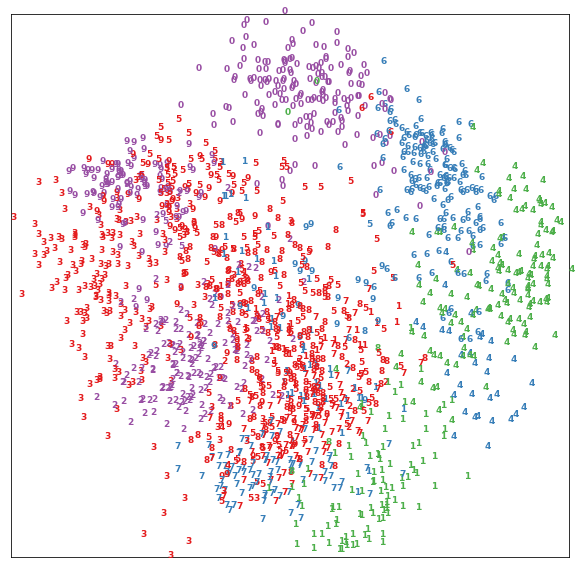

In [69]:
import matplotlib.pyplot as plt
plot_embedding(X_pca, y, predicted_labels_pca, title=None)

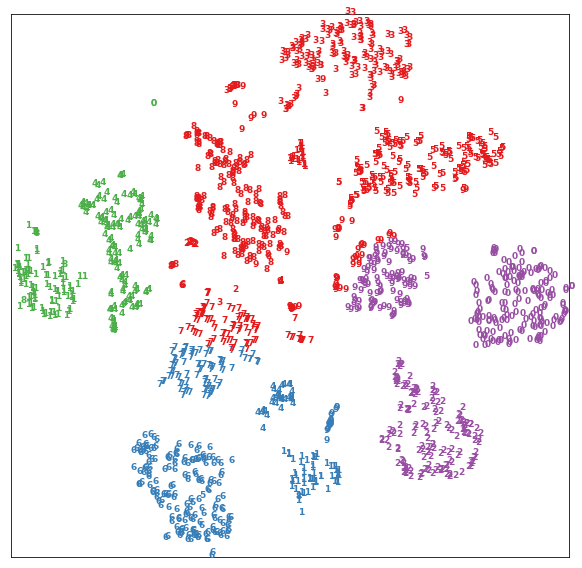

In [70]:
import matplotlib.pyplot as plt
plot_embedding(X_tsne, y, predicted_labels_tsne, title=None)

**(2 балла)** Проанализируйте полученные результаты:
 - какой из трех методов кластеризации: на исходных признаках, на признаках, полученных с помощью PCA или tSNE дал наилучший результат по обеим метрикам?
 - какой из методов сжатия размерности дает наилучшую визуализацию на плоскости?
 - можно ли сказать, что результаты визуализации согласуются с метриками: если кластеры кажутся отделимыми визуально, то и значения метрик выше?
 - как вы думаете: если увеличить число кластеров (то есть взять не 10, а 12, 15 и пр.) может ли кластеризация быть более качественной? Почему?